<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Tunings and Temperaments</p>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython

import matplotlib
plt.rcParams["figure.figsize"] = (14,4)

In [2]:
DEFAULT_SF = 32000  
C4 = 261.63

In [3]:
import ipywidgets as widgets

def play(clip, rate=DEFAULT_SF):
    display(IPython.display.Audio(clip, rate=rate))
    

def multiplay(clips, rate=DEFAULT_SF, title=None):
    outs = [widgets.Output() for c in clips]
    for ix, clip in enumerate(clips):
        with outs[ix]:
            print(title[ix] if title is not None else "")
            display(IPython.display.Audio(clip, rate=rate)  )
    return widgets.HBox(outs)

In [4]:
class Synthesizer:
    """
    Simple monophonic synthesizer with different tunings and waveform engines.
    Input format is a lists of note/duration pairs, eg [('C4', 2), ('E4', 1), ('G4', 1)], which
    will be converted into an internal representation of frequency/duration pairs (fdp) according
    to the selected tuning; for instance, the fdp representation of the above line is
        array([[261.63      , 329.63314428, 392.00208052],
               [  2.        ,   1.        ,   1.        ]])
    FDP's are useful for transposition and can be used directly in case of non-standard pitches.
    """

    SF = DEFAULT_SF
    C4 = 261.63
    SEMITONES = {'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3, 'E': 4, 'F': 5, 'F#': 6, 'Gb': 6, 
                 'G': 7, 'G#': 8, 'Ab': 8, 'A': 9, 'A#': 10, 'Bb': 10, 'B': 11}  
    TUNINGS = {
        'equal': [2.0 ** (n / 12.0) for n in range(0, 12)],
        'just' : [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8],
        'pythagorean': [1, 256/243, 9/8, 32/27, 81/64, 4/3, 729/512, 3/2, 128/81, 27/16, 16/9, 243/128],
    }
    
    time_scale = 0.35  
    tuning = 'equal'
    
    @classmethod
    def taper(cls, x, len_sec=0.02):
        """Taper audio data to zero at both ends"""
        N = int(len_sec * cls.SF)
        x[0:N] *= np.linspace(0, 1, N)
        x[-N:] *= np.linspace(1, 0, N)
        return x
    
    @classmethod
    def glissando(cls, start, stop, len_sec):
        """Create a linear chirp with specific range and duration"""
        N = int(len_sec * cls.SF)
        c = (stop - start) / N / 2
        n = np.arange(0, N)
        chirp = np.cos(2 * np.pi / cls.SF * (c * n + start) * n)
        return cls.taper(chirp)

    # waveform engines; these functions take a digital frequency and a duration in samples
    def sas(self, w, N):
        """Simple additive synthesis"""
        x = np.zeros(N)
        for k, p in enumerate([0.86805556, 0.06510417, 0.03038194, 0.02777778, 0.00303819, 0.00564236]): #[0.6, 0.5, 0.3, 0.4, 0.1]):
            x += p * np.sin(k * w * np.arange(0, N))
        return x
    
    def sine(self, w, N):
        return np.sin(np.arange(0, N) * w)
    
    ENGINES = {
        'additive': sas,
        'sine': sine
    }
    
    def __init__(self, tuning='equal', SF=DEFAULT_SF):
        assert tuning in self.TUNINGS.keys(), 'Unknown tuning/intonation'
        self.tuning = tuning
        self.SF = float(SF)
    
    def parse(self, notes, tuning=None) -> 'frequency/time pairs':
        """
        Convert a series of notes into an array of frequency and duration values 
        using a specific tuning
        """
        # if format is already FTP no need to convert
        if isinstance(notes, np.ndarray) and notes.ndim == 2:
            return notes
        tuning = tuning or self.tuning
        assert tuning in self.TUNINGS.keys(), 'Unknown tuning/intonation'
        fda = np.zeros((2, len(notes)))
        for ix, note in enumerate(notes): 
            # if not specified, default duration is 1
            note = note if isinstance(note, tuple) else (note, 1.0)
            if isinstance(note[0], str):
                # convert notation to frequency
                s = self.SEMITONES[note[0][:-1]]
                octave = int(note[0][-1]) - 4
                fda[0][ix] = self.C4 * (2 ** octave) * self.TUNINGS[tuning][s]
            else:
                fda[0][ix] = note[0]
            fda[1][ix] = note[1]
        return fda
        
    def play(self, score, time_scale=None, engine=None, tuning=None):
        """
        Syntesize audio data from a melody line (either in note/duration format or in frequency/duration 2xN array)
        time_scale adjusts the timebase
        engine selects the waveform generator
        tuning selects the tuning for melodies expressed with note names
        """
        engine = engine or 'additive'
        time_scale = time_scale or self.time_scale
        fda = self.parse(score, tuning)
        s = np.array([])
        for n in range(0, len(fda[0])):
            w = 2 * np.pi * fda[0][n] / self.SF
            N = int(fda[1][n] * self.SF * time_scale)
            s = np.r_[s, self.taper(self.ENGINES[engine](self, w, N))]
        return s

# A well-known "formula"

<img width="800" style="margin: 0;" src="img/piano_ref.jpg">

<br>
$$
    \large p_n = p_0 \left(\sqrt[12]{2}\right)^{n-n_0} 
$$

## Simple questions, surprisingly complex answers...

<br><br>
<img width="250" style="float: left; margin: 10px 20px;" src="img/scale.png">


 * why are there 7 notes in our Western musical scale?
 * why do piano keys repeat in patterns of 12?
 * why are guitar frets spaced that way?
 
 
<img width="450" style="float: right; margin: 10px 20px;" src="img/piano_full.jpg">

<br>

<img width="350" style="float: left; margin: 10px 20px;" src="img/guitar.png">
 


# Musical pitch

Our ears interpret a changing pattern in air pressure as sound. If the pressure pattern repeats periodically, we experience a sensation of **pitch**.

Pitch is determined by the pattern's **frequency** (i.e. the number of times per second that the pattern repeats). The actual *shape* of the pattern only affects what we call the _timbre_ of the sound (note: _affects_ not _determine_ ; many more things go into our sense of timbre). 

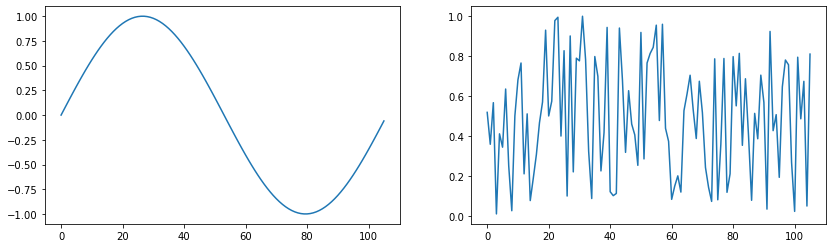

In [5]:
sine = np.sin(np.linspace(0, 2 * np.pi, DEFAULT_SF // 300, endpoint=False))
burst = np.random.rand(DEFAULT_SF // 300)

plt.subplot(1, 2, 1)
plt.plot(sine);    
plt.subplot(1, 2, 2)
plt.plot(burst);    
plt.show()

multiplay([np.tile(sine, 300), np.tile(burst, 300)])

The actual mechanics of sound production will enter the story a bit later. For now, let's use the simplest form of periodic patterns, namely, **sinusoids**. 

## Continuum and categorical perception

<img width="450" style="float: right; margin: 10px 20px;" src="img/piano.jpg">

Pitch spans a sensory _continuum_ ; but most musical practice subdivides this continuum into a discrete set of *named* musical notes.

A piano keyboard is the prototypical illustration of quantized pitch:

 * the 7-note diatonic scale (C, D, E, F, G, A, B, the white keys) 
 * the 12-note chromatic scale (white AND black keys)

In [6]:
synth = Synthesizer()

diatonic_scale = ('C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5')
chromatic_scale = ('C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5')

multiplay([synth.glissando(C4, 2 * C4, 3.0), 
           synth.play(diatonic_scale, engine='sine', time_scale=0.4),
           synth.play(chromatic_scale, engine='sine', time_scale=0.25)], 
          title=['continuum', 'diatonic', 'chromatic'])

## Pitch, melody, harmony and the musical scale
 
 * why 7 notes?
 * why 12 semitones?

### Aside: human categorical perception seems to always generate $7 \pm 2$ classes

![spectrum](img/spectrum.jpg)


(Newton got pretty hung up on this but, really, we can quantize pitch over an arbitrary number of levels...)

## Key Fact #1: melodic information is encoded by frequency _ratios_ , not differences

![fj](img/fj.jpg)

In [7]:
frere_jacques = (('C4', 1), ('D4', 1), ('E4', 1), ('C4', 1), ('C4', 1), ('D4', 1), ('E4', 1), ('C4', 1), ('E4', 1), 
                 ('F4', 1), ('G4', 2), ('E4', 1), ('F4', 1), ('G4', 2))

play(synth.play(frere_jacques))

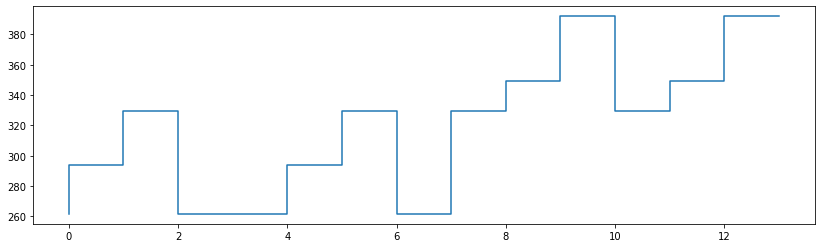

In [8]:
fj_fda = synth.parse(frere_jacques)
plt.step(range(0, len(fj_fda[0])), fj_fda[0]);

### Transposition

Shifting the frequencies corrupts the melodic information, whereas scaling does not:

In [9]:
fj_fda_offset = fj_fda + [[110], [0]]
fj_fda_scaled = fj_fda * [[np.sqrt(2)], [1]]

multiplay([synth.play(fj_fda), synth.play(fj_fda_offset), synth.play(fj_fda_scaled)], 
          title=['original', 'frequency offset', 'frequency scaling'])

### Harmony

In general, however, randomly scaled melodies do not sound good together!

In [10]:
play(synth.play(fj_fda) + synth.play(fj_fda_scaled))

(remember DTMF dialing?)

But there is one exception that everyone knows: melodies separated by one or more _octaves_. 

## Key Fact #2 fact: octaves are innately consonant

<img width="250" style="float: right; margin: 10px 20px;" src="img/choir.jpg">

People singing together tend to sing either in unison or one octave apart (e.g. men and women).

Nature or nurture? Probably both.

To go up an octave, frequencies are _doubled_ ; to go down an octave, frequencies are _halved_ .

In [11]:
play(synth.play(fj_fda) + synth.play(fj_fda * [[2], [1]]))

we can also go up multiple octaves if we use powers of two

In [12]:
play(synth.play(fj_fda) + synth.play(fj_fda * [[2 ** 2], [1]]))

or go down using negative powers of two

In [13]:
play(synth.play(fj_fda) + synth.play(fj_fda * [[2 ** (-1)], [1]]))

### Octave equivalence

**The consonance of octaves is the fundamental principle behind most tunings and temperaments.**

Since musical notes one or more octaves apart induce the same categorical perception we only need to "quantize" an octave.



In [14]:
def map_to_octave(root, freqs):
    for ix in range(0, len(freqs)):
        while freqs[ix] < root:
            freqs[ix] *= 2.0
        # use 2.11 to allow for sligthly "wide" octaves (2.11 ~ 2^(13/12))
        while freqs[ix] > 2.11 * root:  
            freqs[ix] /= 2.0
    return freqs    

## Are there other scaling factors that produce consonant pitches? 

First, let's consider how sound can be generated by a vibrating string (or an organ pipe)

### The Monochord and the vibrating string

<img width="650" style="float: right; margin: 10px 20px 10px 40px;" src="img/monochord.png">

Simple monophonic instrument used in ancient Greece (VI century BC). The motion of the vibrating string can be decomposed into the sum of harmonic standing waves with frequencies

$$ f_n = \frac{n}{2L}\sqrt{\frac{T}{\mu}} $$

 * $L$ length ($m$)
 * $T$ tension ($N = {kg}~ m/s^2$)
 * $\mu$ linear density ($kg/m$)


### Harmonic spectra

Naturally occurring pitched sounds possess a _harmonic_ spectrum, with energy pooled around multiples of the fundamental frequency $f_1$. 

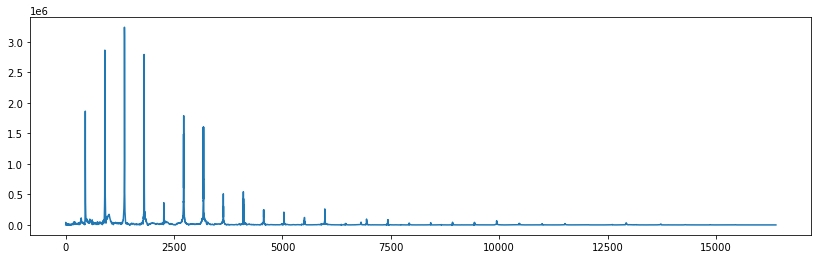

In [15]:
from scipy.io import wavfile
Fs, x = wavfile.read("snd/piano.wav")
x = x - np.mean(x)
play(x, rate=Fs)
plt.plot(np.abs(np.fft.fft(x)[0:int(len(x)/2)]));

The harmonic nature of the spectrum will be important later, for now let's just consider the fundamental frequency.

### The Fifth

<img width="350" style="float: right; margin: 10px 20px 0 50px;" src="img/pythagoras.jpg">

It was known since antiquity that two vibrating strings (with equal tension and density) will sound well together if the length of the second string is **two thirds** of the first. This correspond of a frequency scaling factor equal to $3/2 = 1.5$

The $3/2$ frequency ratio is called a **fifth** (for anachronistic reasons that will be clear later...)

In [16]:
play(synth.play(fj_fda) + synth.play(fj_fda * [[3/2], [1]]))

### The fourth

Another OK ratio is $4/3$ (called the **fourth**), which corresponds to pairing a vibrating string with another three fourths of its length.

In [17]:
play(synth.play(fj_fda) + synth.play(fj_fda * [[4/3], [1]]))

But the fourth is actually just a fifth in disguise under the principle of octave equivalence since

$$ \frac{4}{3} = \left(\frac{3}{2}\right)^{-1}\cdot 2 $$

that is, we go _down_ a fifth and then bring the result back to the original octave. We are now ready for the first tuning.

# Pythagorean Tuning

 * start on a frequency $f_0$
 * the most consonant frequency to $f_0$ (besides unison and octave) is going to be $f_1 = (3/2)f_0$
 * the most consonant frequency to $f_1$ will be $(3/2)f_1 = (3/2)^2f_0$, and so on
 
Let's apply this iteratively seven times, and bring all resulting pitches back to the home octave

In [18]:
pds = map_to_octave(C4, [C4 * ((3/2) ** n) for n in range(-1, 6)])

play(synth.play(pds))

OK, let's sort the notes by increasing frequency:

In [19]:
play(synth.play(sorted(pds)))

Now let's do the same but go 12 times instead

In [20]:
pcs = sorted(map_to_octave(C4, [C4 * ((3/2) ** n) for n in range(0, 13)]))
multiplay((synth.play(pcs), synth.play(chromatic_scale)), title=('pythagorean', 'modern chromatic'))

## The Pythagorean Comma

It would appear we have subdivided the octave into 12 steps (the 12 semitones we are accustomed to). But did we?

In [21]:
play(synth.play([2 * pcs[0], pcs[-1]], time_scale=1))

In [22]:
pcs[-1] / (2 * pcs[0])

1.0136432647705078

### An unsolvable equation

$$\left(\frac{3}{2}\right)^{n} \cdot 2^{-k} = 1, \qquad n, k \in \mathbb{N}$$

### The circle is in fact a spiral

<img width="450" style="float: right; margin: 0 50px 0 0;" src="img/spiral.png">


The "best" approximation defines the Pytagorean comma:

$$\left(\frac{3}{2}\right)^{12} \cdot 2^{-7} = 1.0136432647705078$$

and, for over 2000 years, people have gone around in circles (spirals?) to "temper" the comma...

**Note on the meaning of "best approximation"**

The size of the Pytagorean comma is very small considering that the approximation produces a reasonable number of notes (12) and spans a reasonable  number of octaves (7). As a comparison, the next best approximations would be

| size of the comma | notes per octave | octaves used |
|-------|-------|-----|
| 0.013643264770507812 | 12 | 7 |
| 0.011397452270387465 | 41 | 24 |
| 0.002090314041086172 | 53 | 31 |
| 0.0010217168234779583 | 306 | 179 |
| 0.0000436550634432819 | 665 | 389 |

## Time for some nomenclature

![scaledeg](img/scaledeg.png)

## The dirty secrets of Pythagorean tuning

### The Wolf fifth

Because of the comma, there are 11 perfect fifths and one "wolf" fifth

In [23]:
psynth = Synthesizer('pythagorean')

play(psynth.play(['G3', 'G#3', 'A3', 'A#3', 'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4']) + 
     psynth.play(['D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5']))

The wolf fifth for C-centered tunings is usually between F# and C# 

In [24]:
play(psynth.play(('F#4',), time_scale=2) + psynth.play(('C#5',), time_scale=2))

### The thirds are bad!

The Greeks were not that interested in polyphonic music, and it shows in the bad thirds of Pythagorean tuning 

In [25]:
def triads(syn, ts=2):
    triads = [ [('C4', 2), ('D4', 1)], ['E4', 'F4', 'G4'], ['G4', 'A4', 'B4'] ]  
    return syn.play(triads[0], time_scale=ts) + syn.play(triads[1], time_scale=ts) + syn.play(triads[2], time_scale=ts)

multiplay((triads(Synthesizer('just')), triads(psynth)), title=('nice triads, baby!', 'ouch, pythagoras!!'))

In particular, (major) thirds were considered dissonant by the Greeks... and with reason:

In [26]:
play(psynth.play(('C4',), time_scale=2) + psynth.play(('E4',), time_scale=2))

However, polyphonic singing in the 13th century started to use thirds, but thirds that _sounded good_ !

<audio controls src="img/Sumer is cumen.mp3"></audio>

How did they do it?

# Just Intonation

Just intonation bypasses the geometric construction of Pythagorean tuning and defines the degrees of the scale in terms of "what sounds good". This intonation is also known as the Ptolemaic tuning.

It turns out that most good intervals are described by simple fractions!

## JI & superparticular ratios

| interval | frequency ratio |
|-------|-------|
| I | 1 |
| II | 9/8 |
| III | 5/4 |
| IV | 4/3 |
| V | 3/2 |
| VI | 5/3 |
| VII | 15/8 |
| VIII | 2 |

In [27]:
jsynth = Synthesizer('just')
t = 0.8
js = jsynth.play(('C4',), time_scale=t*8) + jsynth.play(diatonic_scale, time_scale=t)
ts = synth.play(('C4',), time_scale=t*8) + synth.play(diatonic_scale, time_scale=t)
multiplay((js, ts), title=('just intonation', '"modern" intonation'))

## But... why?

Consonance and dissonance for real-world musical sound has a lot to do with the harmonic nature of the associated spectra. Let's unpack this a bit at a time.

### Frequency beatings

Two sinusoidal tones close in frequency produce so-called beatings: the sound is perceived as a single tone modulated in amplitude at a rate equal to the difference between frequencies:

$$
    \cos(\omega_a n) + \cos(\omega_b n) = 2\cos\left(\frac{\omega_a - \omega_b}{2} n\right)\cos\left(\frac{\omega_a + \omega_b}{2} n\right)
$$

If $\omega_a \approx \omega_b$, then:
 * $(\omega_a + \omega_b)/2 \approx \omega_a $
 * $(\omega_a - \omega_b)/2$  is small

In [28]:
def beats(freq, delta=4):
    LEN = 4 # seconds
    n = np.arange(0, int(LEN * DEFAULT_SF))
    s = np.cos(2 * np.pi * freq / DEFAULT_SF * n) + np.cos(2 * np.pi * (freq + delta) / DEFAULT_SF * n)
    if delta != 0:
        K = int(DEFAULT_SF / (2 * abs(delta)))
        s = s[K:]
    plt.plot(s[0:int(DEFAULT_SF)])    
    play(Synthesizer.taper(s))

In [29]:
widgets.interact(beats, freq=widgets.fixed(2 * C4), delta=(0,150));

interactive(children=(IntSlider(value=4, description='delta', max=150), Output()), _dom_classes=('widget-inter…

### The critical band

<img width="450" style="float: right; margin: 10px 20px;" src="img/cochlea.png">

The basilar membrane in the cochlea is composed of frequency-selective regions called _critical bands_ . The ear can only resolve frequencies falling in distinct critical bands, whose spacing is logarithmic. Critical bands are also involved in the mechanism of _masking_ used in lossy audio compression.

Beatings occur when a "blurry" spectral perception induces an unwanted temporal perception. Beatings are generally considered unpleasant.

### Perceptual dissonance curves

A classic psychoacoustic experiment by Plompt and Levelt (1965) produced a model for the relation between the perceptual concept of consonance/dissonance and the physical nature of critical bands. Listeners are asked to rate the level of dissonance between two sinudoidal tones like so:

In [30]:
play(synth.play(['C4',], engine='sine', time_scale=10) + synth.glissando(C4, 2*C4, 10))

Pooled data across listeners produce a dissonance curve parametrized by the reference frequency:

In [31]:
def plc(F, A=1, f=np.linspace(1, 2, 1000), a=None):
    # Plompt-Levelt dissonance curve for sinusoidal tones; F is the base frequency with amplitude A
    #  f is a list of frequency ratios wrt F and a is the amplitude of each tone in f
    A1, A2, C1, C2 = -3.51, -5.75, 5.0, -5.0
    D, S1, S2 = 0.24, 0.0207, 18.96
    d = F * np.abs(1 - f) * D / (S1 * F * np.minimum(1, f) + S2)
    a = np.minimum(A, 1.0) if a is None else np.minimum(A, a)
    return (C1 * np.exp(A1 * d) + C2 * np.exp(A2 * d)) * a

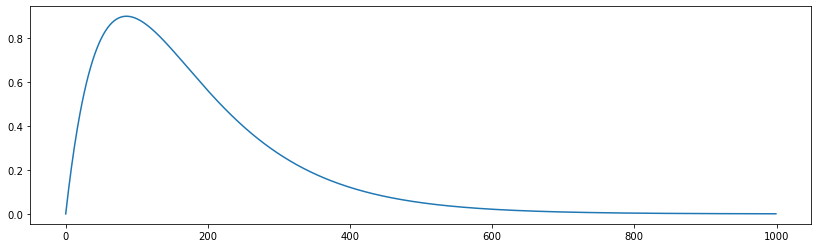

In [32]:
plt.plot(plc(C4));

and the shape of the dissonance curves reflects the _tonotopic_ structure of the basilar membrane in the cochlea.

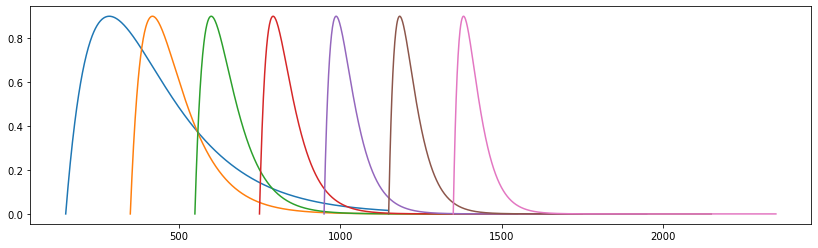

In [33]:
for f in range(150, 1500, 200):
    d = plc(f)
    plt.plot(np.arange(f, f+len(d)), d);

### Consonance and dissonance for harmonic spectra: the simple cases

Octaves sound good together because all partials overlap and so there are no frequency lines that are closely spaced

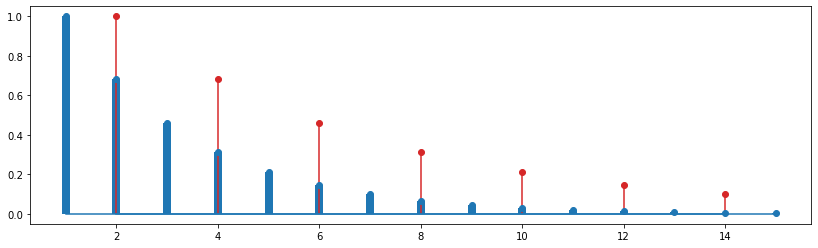

In [34]:
partials = np.arange(1, 100)
amplitudes = 0.68 ** (partials - 1)
_, stems, __ = plt.stem(partials[:15], amplitudes[:15], basefmt='C0', use_line_collection=True);
plt.setp(stems, 'linewidth', 8)
plt.stem((partials * 2)[:7], amplitudes[:7], 'C3-', markerfmt='C3o', basefmt='C0', use_line_collection=True);

In fifths, half of the partials overlap while the others are separated by half of the size of the interval, so the consonance is good.

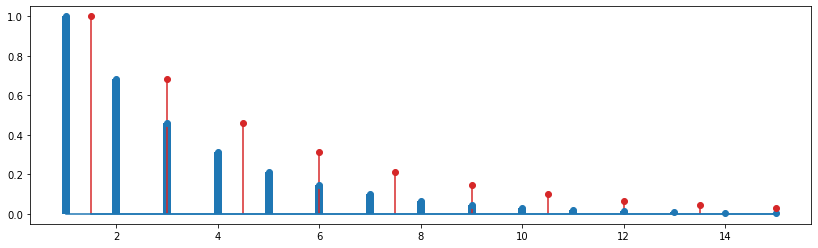

In [35]:
_, stems, __ = plt.stem(partials[:15], amplitudes[:15], basefmt='C0', use_line_collection=True);
plt.setp(stems, 'linewidth', 8)
plt.stem((partials * 3 / 2)[:10], amplitudes[:10], 'C3-', markerfmt='C3o', basefmt='C0', use_line_collection=True);

### Consonance of complex tones

The Plompt-Levelt curve applies to pairs of pure sinusoids. To determine the consonance of two harmonic spectra, we can accumulate the dissonance scores for all pairs of spectral lines in the two tones:

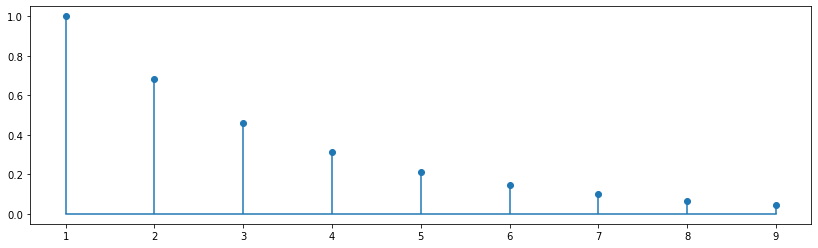

In [36]:
partials = np.arange(1, 10)
amplitudes = 0.68 ** (partials - 1)
plt.stem(partials, amplitudes, basefmt='C0', use_line_collection=True);

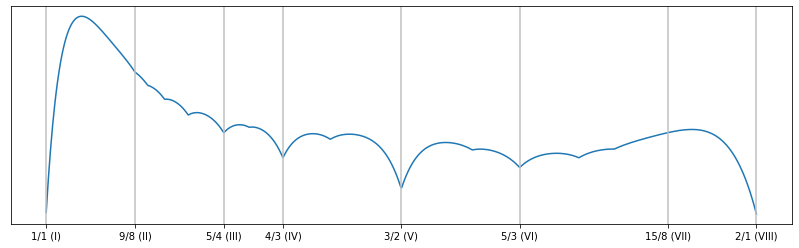

In [37]:
root = C4

sweep = np.linspace(1, 2, 1000)
diss = np.zeros(len(sweep), dtype=float)
for n in range(0, len(sweep)):
    for m in range(0, len(partials)):
        diss[n] += np.sum(plc(root * partials[m], amplitudes[m], sweep[n] * partials / partials[m], amplitudes)) 

plt.plot(sweep, diss);
intervals = [(1, 1, 'I'), (9,8, 'II'), (5, 4, 'III'), (4, 3, 'IV'), (3, 2, 'V'), (5, 3, 'VI'), (15, 8, 'VII'), (2, 1, 'VIII')]
for n, d, _ in intervals:
    plt.axvline(n/d, color='silver');
plt.xticks([n/d for n, d, _ in intervals], ['{}/{} ({})'.format(n, d, i) for n, d, i in intervals]);
plt.yticks([]);

## Another consequence of the harmonic nature of pitched sounds

Why do we like major chords so much?

Major chords are hidden in plain sight in every harmonic series 

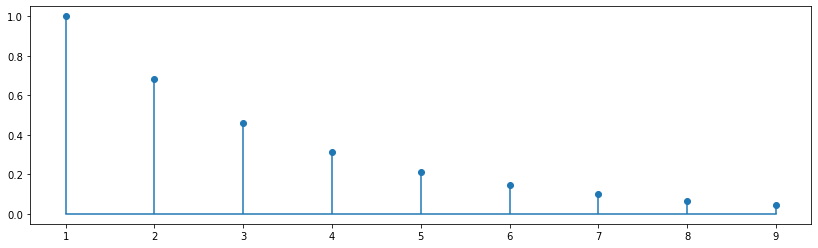

In [38]:
plt.stem(partials, amplitudes, basefmt='C0', use_line_collection=True);

| partial | frequency ratio in base octave | degree | note name
|-------|-------|-----|-----|
| 1st | 1 | 1 | unison | C |
| 2nd | $2 \cdot 2^{-1} = 1$ | unison | C |
| 3rd | $3 \cdot 2^{-1} = 3/2$ | perfect fifth | G |
| 4th | $4 \cdot 2^{-2} = 1$ | unison | **C** |
| 5th | $5 \cdot 2^{-2} = 5/4$ | just third | **E** |
| 6th | $6 \cdot 2^{-2} = 3/2$ | perfect fifth | **G** |
| 7th | $7 \cdot 2^{-2} = 7/4$ | subminor seventh | ~Bb |


In [39]:
cmaj = jsynth.play(('C4',), time_scale=2) + jsynth.play(('E4',), time_scale=2) + jsynth.play(('G4',), time_scale=2)
play(cmaj)

## The dirty secret of Just Intonation: the comma pump

Zarlino (XVI century) considered JI the only intonation suitable for singing. But a cappella groups singing in JT are prone to the so-called _comma pump_.

![fmp](img/fmp.jpg)

### An example of comma pump

![commapump](img/commapump.png)

In [40]:
cp = [C4]
for r in [3/2, 3/4, 3/2, 3/4, 4/5]:
    cp.append(cp[-1] * r)

play(synth.play(cp, time_scale=0.6))

In [41]:
play(synth.play((cp[0], cp[-1]), time_scale=1))

### The Syntonic comma

$$f_0 \cdot \frac{3}{2} \cdot \left(\frac{4}{3}\right)^{-1} \cdot \frac{3}{2} \cdot \left(\frac{4}{3}\right)^{-1} \cdot \left(\frac{5}{4}\right)^{-1} = \frac{81}{80}f_0 = 1.0125 f_0$$

| comma | value |
|-------|-------|
| Pythagorean | 1.01364 |
| Syntonic | 1.0125 |

# Equal temperament

Temperament: an attempt to distribute and therefore hide the comma (aka " *taming the wolf* ")

Equal temperament eliminates both the Pythagorean and the Syntonic commas...

... at the price of having _all_ intervals slightly out of tune! (but we're used to it, so we think it's normal)

## 12-TET

<img width="450" style="float: right; margin: 10px 20px;" src="img/circle-of-fifths.jpg">

And thus we close the circle: octave equivalence gives us the "2" and Pythagoras the "12"


$$\Large p_n = p_0 \left(\sqrt[12]{2}\right)^{n-n_0} $$


<br><br>

$$\sqrt[12]{2} \approx 1.06$$

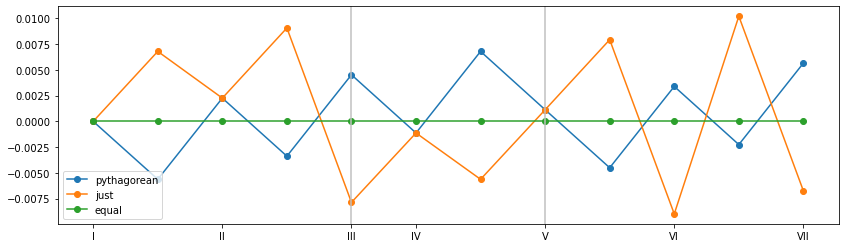

In [42]:
equal = np.array([2.0 ** (n / 12.0) for n in range(0, 12)])
just  = np.array([1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8])
pyth  = np.array([1, 256/243, 9/8, 32/27, 81/64, 4/3, 729/512, 3/2, 128/81, 27/16, 16/9, 243/128])

plt.plot(pyth / equal - 1, 'C0o-', label='pythagorean')
plt.plot(just / equal - 1, 'C1o-', label='just')
plt.plot(equal / equal - 1, 'C2o-', label='equal')
plt.legend(loc="lower left")
plt.axvline(4, color='silver');
plt.axvline(7, color='silver');
plt.xticks([0, 2, 4, 5, 7, 9, 11], ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']);

## Other equal temperaments

![https://en.wikipedia.org/wiki/Equal_temperament](img/equalTemps.png)

## The problem with unusual temperaments....


<img width="450" style="float: left; margin: 100px 50px 0 0;" src="img/split.jpg">
<img width="450" style="float: right; margin: 100px 800px 0 0;" src="img/microtonal.jpg">


## How do N-TET's sound for N < 12?

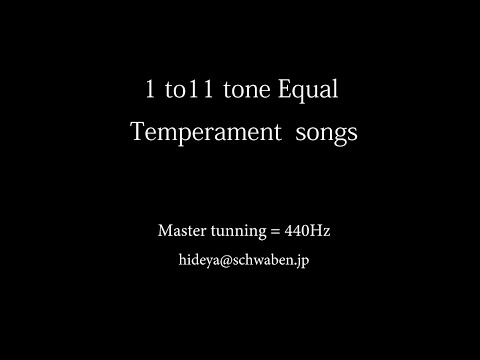

In [43]:
from IPython.display import Audio,Image, YouTubeVideo
id='5zaiOBSQV_Q'
YouTubeVideo(id=id,width=600,height=300)

# Dessert for thought: the Bohlen-Pierce scale

What if we traded the octave-based equivalence for another form of equivalence?

For instance, use a three-to-one ratio for equivalence rather than a two-to-one.

## The equally-tempered BP scale

$$\Large p_n = p_0 \left(\sqrt[13]{3}\right)^{n-n_0} $$

## Standing waves in pipes and overblowing

![](img/opencloseD.gif)

## How does it sound?

Remember how the fundamental major triad in western music is based on harmonics 4, 5, and 6:

In [44]:
bp_triad = np.array((C4 / 4) * np.array([4, 5, 6]))
play(Synthesizer().play(bp_triad, time_scale=0.6))

The BP "major triad" is based on the odd harmonics 3, 5, and 7  

In [45]:
bp_triad = np.array((C4 / 3) * np.array([3, 5, 7]))
play(Synthesizer().play(bp_triad, time_scale=0.6))


<img width="450" style="float: right; margin: 0 50px 0 0;" src="img/bp.jpg">


Once we have the "major" triad, the rest of the BP diatonic scale can be built in several ways; the most common one uses equal temperament over 13 semitones.

(details in the references) 

In [46]:
bp = np.array([3.0 ** (n / 13.0) for n in [0, 2, 3, 4, 6, 7, 9, 10, 12, 13]])
play(Synthesizer().play(C4 * bp, time_scale=0.3))

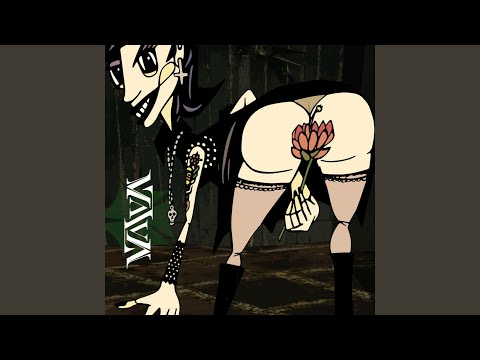

In [47]:
id='uclITdD4dAo'
YouTubeVideo(id=id,width=600,height=50)

# References

 * Plompt and Levelt's paper: https://www.mpi.nl/world/materials/publications/levelt/Plomp_Levelt_Tonal_1965.pdf
 * Very exhaustive book on tunings and temperaments: https://www.braybaroque.ie/temper/
 * Common tunings for harpsichord: https://www.hpschd.nu/
 * The harmonic overtone series: https://en.wikipedia.org/wiki/Harmonic_series_(music)#Partial
 * Just intonation explained: https://www.kylegann.com/tuning.html, http://www.hermode.com/history_en.html
 * Lois Lancaster: https://selonetlabel.bandcamp.com/album/malva